In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
# subset to relevant urls
humanist_urls = ["https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/", "https://humanist.kdl.kcl.ac.uk/Archives/Current/"]
volume_dfs = []
# loop through each url
for url in humanist_urls:
    print(f"Getting volumes from {url}")
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all('a')
    # loop through each volume link
    for link in links:
        if link['href'].endswith('.txt'):
            print(f"Getting volume from {url + link['href']}")
            page_soup = BeautifulSoup(requests.get(url + link['href']).text, "html.parser")
            text = page_soup.get_text()
            volume_link = url + link['href']
            dates = link['href'].split('.')[1]
            data_dict = {'volume_text': text, 'volume_link': volume_link, 'volume_dates': dates}
            volume_dfs.append(data_dict)

scraped_humanist_df = pd.DataFrame(volume_dfs)
# Extract the volume number from the dates
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_dates'].str.extract(r'(\d+)')
# Remove numbers with more than 2 digits
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_number'].apply(lambda x: np.nan if len(str(x)) > 2 else x)

# Replace nulls with a sequential of volume numbers
scraped_humanist_df['volume_number'] = scraped_humanist_df['volume_number'].fillna(pd.Series(np.arange(1, len(scraped_humanist_df) + 1)))

# Extract the start and end years
scraped_humanist_df[['inferred_start_year', 'inferred_end_year']] = scraped_humanist_df['volume_dates'].str.split('-', expand=True)

# Remove years that are not 4 digits
scraped_humanist_df.inferred_start_year = scraped_humanist_df.inferred_start_year.apply(lambda x: np.nan if len(str(x)) != 4 else x)
scraped_humanist_df.inferred_end_year = scraped_humanist_df.inferred_end_year.apply(lambda x: np.nan if len(str(x)) != 4 else x)

# Ensure the years are numeric
scraped_humanist_df.loc[scraped_humanist_df.inferred_end_year.isnull(), 'inferred_end_year'] = np.nan

# Create an empty dummy variable for the years
start_year_before = None
end_year_before = None

# Loop through dataframe row by row
for index, row in scraped_humanist_df.iterrows():
    # Check that both start and end years are not null
    if (not pd.isnull(row.inferred_start_year)) and (not pd.isnull(row.inferred_end_year)):
        # assign the years to the dummy variables
        start_year_before = row.inferred_start_year
        end_year_before = row.inferred_end_year
        # print the years
        print(start_year_before, end_year_before)
    # Check that if years are null and the dummy variables are not, then update the years in the dataframe
    elif (pd.isnull(row.inferred_start_year) and start_year_before is not None) and (pd.isnull(row.inferred_end_year) and end_year_before is not None):
        # increment the years by 1
        start_year_before = int(start_year_before) + 1
        end_year_before = int(end_year_before) + 1
        # assign the years to the dataframe using the row index to update the original dataframe
        scraped_humanist_df.at[index, 'inferred_start_year'] = start_year_before
        scraped_humanist_df.at[index, 'inferred_end_year'] = end_year_before
        print(start_year_before, end_year_before)

# Save the dataframe to a csv
scraped_humanist_df.to_csv("web_scraped_humanist_listserv_volumes.csv", index=False)

Getting volumes from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1987-1988.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1988-1989.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1989-1990.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1990-1991.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1991-1992.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1992-1993.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1993-1994.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1994-1995.txt
Getting volume from https://humanist.kdl.kcl.ac.uk/Archives/Converted_Text/humanist.1995-1996.txt
Getting volume from https://humanist.kdl.

In [2]:
"1988-1989".split('-')

['1988', '1989']

In [3]:
import pandas as pd
humanist_vols = pd.read_csv('web_scraped_humanist_listserv_volumes.csv')
# Check the data types of our columns
humanist_vols.dtypes

volume_text            object
volume_link            object
volume_dates           object
volume_number           int64
inferred_start_year     int64
inferred_end_year       int64
dtype: object

In [4]:
humanist_vols['volume_size'] = humanist_vols['volume_text'].str.count('\n')

In [5]:
humanist_vols['humanities_computing_counts'] = humanist_vols['volume_text'].str.count('humanities computing')
humanist_vols['digital_humanities_counts'] = humanist_vols['volume_text'].str.count('digital humanities')

In [6]:
humanist_vols

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,volume_size,humanities_computing_counts,digital_humanities_counts
0,From: MCCARTY@UTOREPAS\nSubject: \nDate: 12 Ma...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1987-1988,1,1987,1988,50794,98,0
1,From: Sebastian Rahtz \nSubject: C++ and Gnu o...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1988-1989,2,1988,1989,36109,55,0
2,From: Willard McCarty \nSubject: Happy Birthda...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1989-1990,3,1989,1990,108695,107,0
3,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1990-1991,4,1990,1991,118929,29,0
4,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1991-1992,5,1991,1992,81193,49,0
5,From: Elaine M Brennan \nSubject: Humanist's B...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1992-1993,6,1992,1993,59957,71,0
6,From: 6500card%ucsbuxa@hub.ucsb.edu (Cheryl A....,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1993-1994,7,1993,1994,71763,41,0
7,From: Andrew Burday \nSubject: Re: 7.0638 Qs: ...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1994-1995,8,1994,1995,46569,28,0
8,"From: ""Gregory Bloomquist"" \nSubject: Round Ta...",https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1995-1996,9,1995,1996,61076,105,0
9,From: Humanist \nSubject: Humanist begins its ...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1996-1997,10,1996,1997,52506,82,0


<AxesSubplot:>

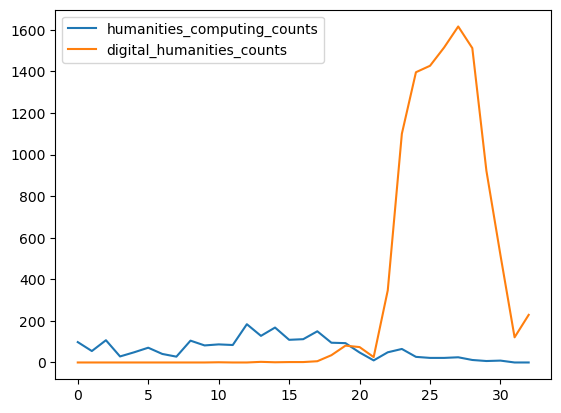

In [7]:
humanist_vols[['humanities_computing_counts', 'digital_humanities_counts']].plot()

In [10]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/seanyoon/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/seanyoon/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/seanyoon/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/seanyoon/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/seanyoon/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to
[nltk_data]    |     /Users/seanyoon/nltk_d

True

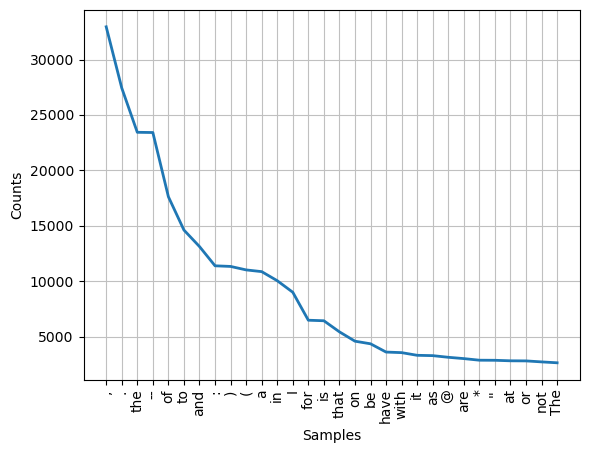

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [11]:
from nltk import word_tokenize
from nltk import FreqDist

tokens = FreqDist(sum(humanist_vols[0:2]['volume_text'].map(word_tokenize), []))
tokens.plot(30)

<AxesSubplot:>

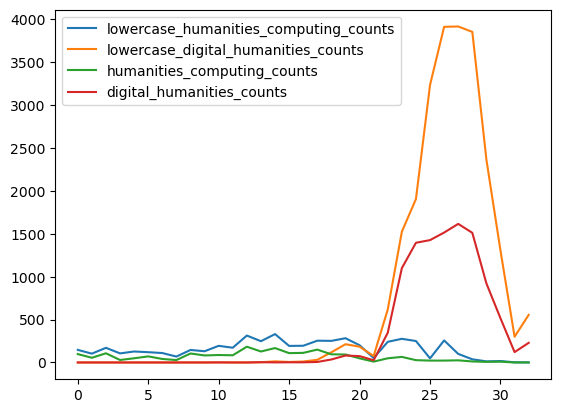

In [9]:
# Count the number of occurrences of each word lowercased
humanist_vols['lowercase_humanities_computing_counts'] = humanist_vols['volume_text'].str.lower().str.count('humanities computing')
humanist_vols['lowercase_digital_humanities_counts'] = humanist_vols['volume_text'].str.lower().str.count('digital humanities')
# Plot the data
humanist_vols[['lowercase_humanities_computing_counts', 'lowercase_digital_humanities_counts', 'humanities_computing_counts', 'digital_humanities_counts']].plot()

In [12]:
import nltk
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [15]:
subset_humanist_vols = humanist_vols[0:2]

def stem_words(row):
    stemmed_words = ''
    for token in row.split(' '):
        stemmed_words += porter.stem(token) + ' '
    return stemmed_words
subset_humanist_vols['stemmed_text'] = subset_humanist_vols.volume_text.apply(stem_words)

print(subset_humanist_vols[0:1]['stemmed_text'].values)

['from: mccarty@utorepas\nsubject: \ndate: 12 may 1987, 23:50:02 edt\nx-humanist: vol. 1 num. 1 (1)\n\nthi is test number 1. pleas acknowledge.\n\nfrom: mccarty@utorepas\nsubject: \ndate: 13 may 1987, 00:06:41 edt\nx-humanist: vol. 1 num. 2 (2)\n\nthi is test number 2. pleas acknowledge.\n\nfrom: mccarty@utorepas\nsubject: \ndate: 13 may 1987, 23:08:57 edt\nx-humanist: vol. 1 num. 3 (3)\n\nthi is a test of a new bitnet mailer for peopl involv with the\nsupport of comput in the humanities. pleas acknowledg receipt of\nthi message. a more complet explan and welcom messag will be\nforthcoming.\nthank veri much.\n\nfrom: ian@utorepas\nsubject: \ndate: 14 may 1987, 16:05:17 edt\nx-humanist: vol. 1 num. 4 (4)\n\nmessag received.\n\nfrom: mccarty@utorepas\nsubject: \ndate: 14 may 1987, 20:17:18 edt\nx-humanist: vol. 1 num. 5 (5)\n\nwelcom to humanist\n \nhumanist is a bitnet/netnorth electron mail network for people\nwho support comput in the humanities. those who teach, review\nsoftware, ans

/var/folders/b7/tsn_c63j6251c6rhj_pfzq1c0000gn/T/ipykernel_93077/487508304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_humanist_vols['stemmed_text'] = subset_humanist_vols.volume_text.apply(stem_words)


In [16]:
stemmed_column = []
for index, row, in subset_humanist_vols.iterrows():
    stemmed_words = ''
    for token in row.volume_text.split(' '):
        stemmed_words += porter.stem(token) + ' '
    stemmed_column.append(stemmed_words)

subset_humanist_vols['stemmed_text'] = stemmed_column

/var/folders/b7/tsn_c63j6251c6rhj_pfzq1c0000gn/T/ipykernel_93077/229752206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_humanist_vols['stemmed_text'] = stemmed_column


In [17]:
# Let's try TF-IDF. This code is from the PH Tutorial linked above
# Import the TfidfVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

#save our texts to a list
documents = subset_humanist_vols.volume_text.tolist()

#Create a vectorizer
vectorizer = TfidfVectorizer(max_df=.7, min_df=1)

In [18]:
# Fit the vectorizer to our documents
transformed_documents = vectorizer.fit_transform(documents)

# Now get the top features for each document
transformed_documents_as_array = transformed_documents.toarray()

dates = humanist_vols.inferred_start_year.tolist()
tfidf_results = []
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    one_doc_as_df['inferred_start_year'] = dates[counter]
    tfidf_results.append(one_doc_as_df)

In [19]:
tfidf_df = pd.concat(tfidf_results)
tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False)
tfidf_df.head(10)

,term,score,inferred_start_year
0,astra,0.237624,1988
0,pi,0.204532,1987
1,virus,0.190666,1987
2,sep,0.180266,1987
3,ir,0.152532,1987
1,resend,0.152228,1988
3,stallman,0.148515,1988
2,pali,0.148515,1988
4,junger,0.144802,1988
5,hollander,0.129951,1988


In [20]:
print(tfidf_df[0:200].term.unique())

['astra' 'pi' 'virus' 'sep' 'ir' 'resend' 'stallman' 'pali' 'junger'
 'hollander' 'jun' 'hist' 'johnston' 'aug' 'jul' 'pr' 'texpert' 'cmi011'
 'ess' 'isaac' 'makrolog' 'zealand' 'graeme' 'wesolowski' 'glynn' 'connor'
 'wong' 'oikawa' 'hirst' 'marlene' 'vacation' 'brien' 'voorhis' '050'
 'omnipage' 'melby' 'cwru' 'husc6' 'chatter' 'ijcai' 'adamo' 'iubacs'
 'msstate' 'sdr' 'baima' 'whittaker' 'eighteenth' 'nash' 'array'
 'hierarchies' 'tovna' 'mathieu' 'zippy' 'altman' 'beckwith'
 'paralanguage' 'q1' 'peebles' 'mabry' 'halteren' 'cms1' 'patents' 'memdb'
 'heberlein' 'imagewriter' 'estfri' 'gargoyle' 'spitbol' 'deredec' 'snow'
 'fellum' 'locke' 'firms' 'ob' 'rudrum' 'categorization' 'ideally'
 'jeffrey' 'sensible' 'griswold' 'infected' 'oda' 'gillette' 'digesting'
 'honorific' 'paste' 'haviland' 'nov' 'burden' 'goode' 'licensing' 'arl'
 'retro' 'elogium' 'colson' 'laplante' 'mohler' 'mealand' 'typesetters'
 'guest4' 'coling' 'mallard' 'iicx' 'calera' 'ridings' 'colpaert' 'mepham'
 'portor

In [21]:
humanist_vols

,volume_text,volume_link,volume_dates,volume_number,inferred_start_year,inferred_end_year,volume_size,humanities_computing_counts,digital_humanities_counts,lowercase_humanities_computing_counts,lowercase_digital_humanities_counts
0,From: MCCARTY@UTOREPAS\nSubject: \nDate: 12 Ma...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1987-1988,1,1987,1988,50794,98,0,147,0
1,From: Sebastian Rahtz \nSubject: C++ and Gnu o...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1988-1989,2,1988,1989,36109,55,0,103,0
2,From: Willard McCarty \nSubject: Happy Birthda...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1989-1990,3,1989,1990,108695,107,0,171,0
3,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1990-1991,4,1990,1991,118929,29,0,106,0
4,From: Elaine Brennan & Allen Renear \nSubject:...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1991-1992,5,1991,1992,81193,49,0,128,0
5,From: Elaine M Brennan \nSubject: Humanist's B...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1992-1993,6,1992,1993,59957,71,0,120,0
6,From: 6500card%ucsbuxa@hub.ucsb.edu (Cheryl A....,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1993-1994,7,1993,1994,71763,41,0,110,0
7,From: Andrew Burday \nSubject: Re: 7.0638 Qs: ...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1994-1995,8,1994,1995,46569,28,0,69,0
8,"From: ""Gregory Bloomquist"" \nSubject: Round Ta...",https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1995-1996,9,1995,1996,61076,105,0,146,0
9,From: Humanist \nSubject: Humanist begins its ...,https://humanist.kdl.kcl.ac.uk/Archives/Conver...,1996-1997,10,1996,1997,52506,82,0,131,0
